In [4]:
from PIL import Image
import numpy as np 
import os 
import time
import matplotlib.pyplot as plt  
%matplotlib inline

import torch
import torch.nn as nn 
from torch.autograd import Variable
import torchvision
from torchvision import models,transforms,datasets


In [5]:
print(torch.__version__)
use_gpu = torch.cuda.is_available()
print(use_gpu)

2.1.2.post100
False


In [7]:
x = Variable(data = torch.ones(3,3), requires_grad=True)
print(x.data)
print(x.grad)

tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])
None


$$
\begin{align}
f(x) &= \cos x^2\\
g(x) &= \tan^{\frac{1}{4}} x
\end{align}
$$

In [19]:
f = (x*x).cos()
f.retain_grad()
g = x.tan().pow(0.25)
g.retain_grad()

$$
h(x) = \frac{1}{1 + \exp{(f(x)- g(x))}}
$$

In [21]:
h = 1/(1+ (f-g).exp())

In [22]:
s = h.sum()
s.backward( retain_graph=True)

In [24]:
print(x.grad)
print(f.grad)
print(g.grad)

tensor([[1.0581, 1.0581, 1.0581],
        [1.0581, 1.0581, 1.0581],
        [1.0581, 1.0581, 1.0581]])
tensor([[-0.2303, -0.2303, -0.2303],
        [-0.2303, -0.2303, -0.2303],
        [-0.2303, -0.2303, -0.2303]])
tensor([[0.2303, 0.2303, 0.2303],
        [0.2303, 0.2303, 0.2303],
        [0.2303, 0.2303, 0.2303]])


see https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

In [26]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

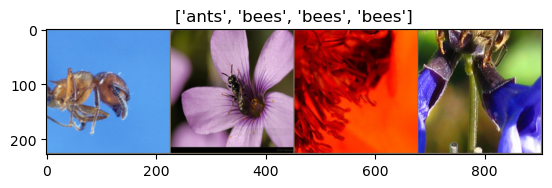

In [27]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [30]:
class Network(nn.Module):

    def __init__(self):
        super(Network, self).__init__()
        self.categories = 1000 #Number of ImageNet categories
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size = 3, padding = 1),
            nn.ReLU(inplace = True),
            nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, padding = 1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, padding = 1),
            nn.ReLU(inplace = True),
            nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 3, padding = 1),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 3, padding = 1),
            nn.ReLU(inplace = True),
            nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = 3, padding = 1),
            nn.ReLU(inplace = True),
            nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = 3, padding = 1),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
        )
        self.block4 = nn.Sequential(
            nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = 3, padding = 1),
            nn.ReLU(inplace = True),
            nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, padding = 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, padding = 1),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
        )
        self.block5 = nn.Sequential(
            nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, padding = 1),
            nn.ReLU(inplace = True),
            nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, padding = 1),
            nn.ReLU(inplace = True),
            nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, padding = 1),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
        )
        self.classify = nn.Sequential(
            nn.Linear(in_features = 512 * 7 * 7, out_features = 4096),
            nn.ReLU(inplace = True),
            nn.Dropout(),
            nn.Linear(in_features = 4096, out_features = 4096),
            nn.ReLU(inplace = True),
            nn.Dropout(),
            nn.Linear(in_features = 4096, out_features = self.categories),
            nn.Softmax(self.categories)
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = x.view(x.size(0), -1)
        x = self.classify(x)
        return x

In [31]:
network = Network()
print(network)

Network(
  (block1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): MaxPo